# Investigating Amazon games reviews

Current dataset is a part of big Amazon review dataset, picked from category games. It is a balanced subsamle, which means that number of reviews of each score is approximately the same. This research aims to predict review score based on review text.

## Data preparation

Read data from file

In [110]:
import json
import numpy as np

texts = []
scores = []

with open("./data/Games_5876.json", "r") as json_file:
    for line in json_file:
        str = json.loads(line)
        texts.append(str["text"])
        scores.append(str["overall"])
        
texts = np.asarray(texts)
scores = np.asarray(scores)

Number of rows in data file: 

In [111]:
len(texts)

5876

Each row in dataset consists of review and score. Review is a combination of short summary that was made uppercase and added before review text. Score is a value from 1.0 to 5.0. Examle:

In [112]:
print(texts[0])
print(scores[0])

THEY ARE JUST OK
These slides are just as they advertised. Now that we have them, I would have preferred to buy a set with just one specimen per slide in a bigger kit. This set is just adequate.
2.0


Number of reviews in each group:

In [113]:
for i in range(1, 6):
    print("Score {}, number of items: {}".format(i, sum(scores == i)))

Score 1, number of items: 1175
Score 2, number of items: 1175
Score 3, number of items: 1176
Score 4, number of items: 1175
Score 5, number of items: 1175


Other reseaches show low results in score classification. Usually, they cannot reach accuracy higher than 60%. It happens because it is difficult to distinguish between scores that are similar, e.g. 1 and 2 or 4 and 5. Instead, we make a binary classification and choose between positive and negative reviews. 1 and 2 is negative; 4 and 5 is positive. Score 3 is ignored, since it is difficult to put it into one of these groups.

In [114]:
texts = texts[scores != 3]
scores = scores[scores != 3]
scores = 3 < scores

for i in [True, False]:
    print("Score {}, number of items: {}".format(i, sum(scores == i)))

Score True, number of items: 2350
Score False, number of items: 2350


Try combinations of different classifiers and vectorizers. First fill different vectorizers.

In [115]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizers = {}
vectorizers["CountVectorizer"] = CountVectorizer()
vectorizers["TfidfVectorizer"] = TfidfVectorizer()

Divide dataset to training and test set. Save different classifiers (Multinomial Naive Bayes, SVM, Random Forest) and tuning parameters for further processing.

In [116]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit

texts_test = []
scores_test = []
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=123)
for train_index, test_index in split.split(texts, scores):
    texts_test = texts[test_index]
    scores_test = scores[test_index]
    texts = texts[train_index]
    scores = scores[train_index]
    
print("Length Train: {} {} Length Test: {} {}".format(len(texts), len(scores), len(texts_test), len(scores_test)))

classifiers = {}
classifiers["MultinomialNB"] = MultinomialNB()
classifiers["LinearSVC"] = LinearSVC(dual=False)

param_grids={} 
param_grids["MultinomialNB"] = {'clf__alpha': (0.1, 1.0)}
param_grids["LinearSVC"] = {'clf__penalty': ('l1', 'l2')}

Length Train: 4230 4230 Length Test: 470 470


Loop through all combinations of vectorizers and models and try different variations of parameters. Apply cross validation and calculate accuracy and AUC value.

In [117]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

np.random.seed(123)
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
results = {}
auc = {}

for vect_name, vectorizer in vectorizers.items():
    for cls_name, classifier in classifiers.items():
        name = "{} {}".format(vect_name, cls_name)
        print("")
        print("Calculating {}".format(name))
        pipeline = Pipeline([
            ('vect', vectorizer),
            ('clf', classifier)
        ])
        
        cls_grid = param_grids[cls_name]
        param_grid = {'vect__max_df': (0.5, 1.0)}
        param_grid = {**param_grid, **cls_grid}
        gs = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=5, refit='AUC', return_train_score=True)
        gs.fit(texts, scores)
        result = gs.cv_results_ 
        print("{}: accuracy = {}; AUC = {};".format(name, result["mean_test_Accuracy"], result["mean_test_AUC"]))
        print("Best score = {}; Best params = {}".format(gs.best_score_, gs.best_params_))
        results[name] = gs.best_estimator_
        auc[name] = gs.best_score_


Calculating CountVectorizer MultinomialNB
CountVectorizer MultinomialNB: accuracy = [ 0.85508274  0.85508274  0.87328605  0.87352246]; AUC = [ 0.92327571  0.92408106  0.93926082  0.93902721];
Best score = 0.9392608241257706; Best params = {'clf__alpha': 1.0, 'vect__max_df': 0.5}

Calculating CountVectorizer LinearSVC
CountVectorizer LinearSVC: accuracy = [ 0.85484634  0.85295508  0.86193853  0.86335697]; AUC = [ 0.9264904   0.92663794  0.93117717  0.93257773];
Best score = 0.9325777263607352; Best params = {'clf__penalty': 'l2', 'vect__max_df': 1.0}

Calculating TfidfVectorizer MultinomialNB
TfidfVectorizer MultinomialNB: accuracy = [ 0.84089835  0.84160757  0.86288416  0.86312057]; AUC = [ 0.92726165  0.92809103  0.94546217  0.94557059];
Best score = 0.945570589451682; Best params = {'clf__alpha': 1.0, 'vect__max_df': 1.0}

Calculating TfidfVectorizer LinearSVC
TfidfVectorizer LinearSVC: accuracy = [ 0.87990544  0.87966903  0.87754137  0.88297872]; AUC = [ 0.95006623  0.95125553  0.9

The best AUC score and accuracy are achieved by LinearSVC and TfidfVectorizer.
Use best estimator on test set to visualize confusion matrix:

In [118]:
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt

estimator = results["TfidfVectorizer LinearSVC"]
score_predict = estimator.predict(texts_test)
conf = ConfusionMatrix(scores_test, score_predict)
print(conf)

Predicted  False  True  __all__
Actual                         
False        206    29      235
True          27   208      235
__all__      233   237      470


Linear SVC model provides coefficients that can be analysed. They show how much each word from dictionary influence the final decision. It's possible to find out the highest absolute values of coefficients and corresponding words. They are visualized on plot below.

Text(0,0.5,'Absolute value of coefficient')

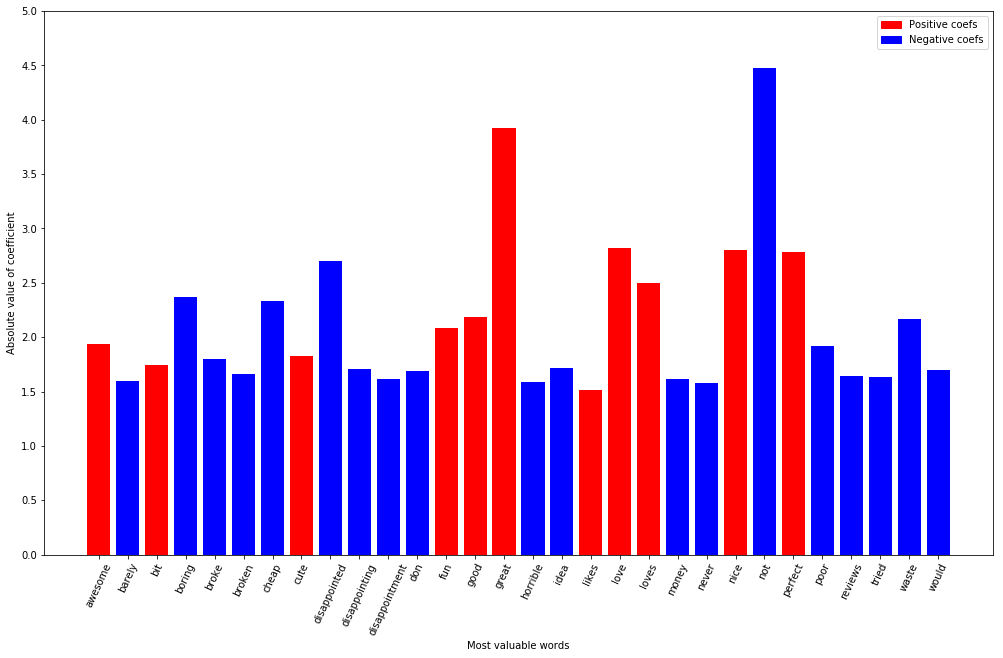

In [119]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

vectorizer = estimator.steps[0][1]
clf = estimator.steps[1][1]

feature_names = vectorizer.get_feature_names()
top_feature_indexes = np.argsort(abs(clf.coef_[0]))[-30:]
top_feature_names = [feature_names[j] for j in top_feature_indexes]
top_feature_coefs = np.asarray([clf.coef_[0][j] for j in top_feature_indexes])
top_feature_coefs_abs = np.asarray([abs(clf.coef_[0][j]) for j in top_feature_indexes])

top_feature_coefs_colors = []
for v in top_feature_coefs:
    if v < 0:
        top_feature_coefs_colors.append('blue')
    else:
        top_feature_coefs_colors.append('red')


plt.figure(figsize=(17, 10))
plt.bar(top_feature_names, top_feature_coefs_abs, align='center', color=top_feature_coefs_colors)
plt.xticks(rotation=65)
plt.yticks(np.arange(0, max(top_feature_coefs_abs) + 1, 0.5))

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='red', label='Positive coefs')
blue_patch = mpatches.Patch(color='blue', label='Negative coefs')
plt.legend(handles=[red_patch, blue_patch])

plt.xlabel('Most valuable words')
plt.ylabel('Absolute value of coefficient')

These words play the highest role in prediction. Red bars correspond to positive values of coefficients. Blue bars to negative. Both groups of words influence the final result. Such words as fun, good, great provide the positive context. Negative one is formed by not, boring, broke, etc. All in all, the combination of Tfidf and LinearSVC model show high efficiency. It achieves high accuracy and provide reasonable sets of most valuable words.